In [3]:
%matplotlib inline
import os
import re
import string
import shutil

from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sn

import sklearn as sk
from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_sample_weight

from gensim.models import KeyedVectors

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, LSTM, Input, GlobalMaxPooling1D, Conv1D, MaxPooling1D, Embedding, Flatten, Concatenate
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tqdm import tqdm, tqdm_notebook, tnrange, trange

In [4]:
tqdm.monitor_interval = 0
tqdm_notebook().pandas()
sn.set_context('notebook')

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

## Prep Text Data

In [ ]:
train = pd.read_pickle('CLEAN/train.P.gz', compression='gzip')

In [6]:
test = pd.read_pickle('CLEAN/test.P.gz', compression='gzip')

In [7]:
print(train.shape)
print(train.columns)
train.iloc[0:5]

(159571, 9)
Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'cleaned_comments'],
      dtype='object')


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_comments
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,False,False,False,False,False,False,explanation \n why the edit make under my user...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,False,False,False,False,False,False,daww he match this background colour I be seem...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",False,False,False,False,False,False,hey man I be really not try to edit war its ju...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",False,False,False,False,False,False,more \n I can not make any real suggestion on ...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",False,False,False,False,False,False,you sir be my hero any chance you remember wha...


In [8]:
print(test.shape)
print(test.columns)
test.iloc[0:5]

(153164, 3)
Index(['id', 'comment_text', 'cleaned_comments'], dtype='object')


,id,comment_text,cleaned_comments
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,yo bitch ja rule be more succesful then you wi...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,from rfc the title be fine as it be imo
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",source zawe ashton on lapland
3,00017563c3f7919a,":If you have a look back at the source, the in...",if you have a look back at the source the info...
4,00017695ad8997eb,I don't anonymously edit articles at all.,I do not anonymously edit article at all


In [ ]:
all_comments = pd.concat([train.cleaned_comments,test.cleaned_comments])
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_comments)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

In [17]:
train_sequences = tokenizer.texts_to_sequences(train.cleaned_comments)

Found 396618 unique tokens.


In [47]:
train_sequences[0]

[581,
 85,
 2,
 41,
 47,
 194,
 29,
 625,
 3683,
 8179,
 774,
 1,
 148,
 46,
 1,
 10,
 228,
 51,
 4835,
 18,
 66,
 1969,
 156,
 4,
 517,
 32,
 125,
 1084,
 7899,
 2144,
 7,
 52,
 14,
 10,
 98,
 2,
 319,
 30,
 2,
 56,
 24,
 152,
 4,
 1,
 2655,
 142857]

In [32]:
lengths = []
for s in tqdm_notebook(train_sequences):
    lengths.append(len(s))
train["seq_len"] = lengths

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 159571/159571 [00:00<00:00, 780291.16it/s]


In [36]:
test_sequences = tokenizer.texts_to_sequences(test.cleaned_comments)
print(test.shape)
print(len(test_sequences))

(153164, 3)
153164


In [37]:
test_lengths = []
for s in tqdm_notebook(test_sequences):
    test_lengths.append(len(s))
test["seq_len"] = test_lengths

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 153164/153164 [00:00<00:00, 741706.39it/s]


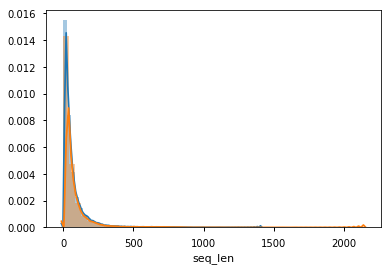

In [38]:
sn.distplot(a=train['seq_len'])
sn.distplot(a=test['seq_len'])

In [39]:
print(max(train['seq_len']))
print(max(test['seq_len']))

1403
2142


In [73]:
# sequence_pad_len=2150
sequence_pad_len=250
train_data = pad_sequences(train_sequences, maxlen=sequence_pad_len)
test_data = pad_sequences(test_sequences, maxlen=sequence_pad_len)

In [74]:
train_data.shape

(159571, 250)

In [75]:
test_data.shape

(153164, 250)

## Preparing the embedding Layer

In [55]:
embedding_dim = 25
import pathlib
sourcedir = pathlib.Path('GLOVE')
embeddings_index = {}
with open(sourcedir / ("glove.twitter.27B.%dd.txt" % embedding_dim), 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
# word2vec = KeyedVectors.load_word2vec_format(
#             os.path.join("W2V",
#                 'w2v.twitter.27B.%dd.txt' % embedding_dim),
#             binary=False)

In [58]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

## Save the Embeddings and Sequences as pickles

In [76]:
import pickle
os.makedirs("NN_INPUTS", exist_ok=True)
with open("NN_INPUTS/train.seq.P", 'wb') as f:
    pickle.dump(train_data, f)
with open("NN_INPUTS/test.seq.P", 'wb') as f:
    pickle.dump(test_data, f)
with open("NN_INPUTS/embedding.matrix.P", 'wb') as f:
    pickle.dump(embedding_matrix, f)
with open("NN_INPUTS/word_index.P", 'wb') as f:
    pickle.dump(word_index, f)